## Assignment 1
# Group 13
Mathieu Mailhot - Isabel Lougheed - Frank-Lucas Pantazis

Imports

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [71]:
"""
- CKD: 28 numerical features, 1 target binary classification variable ("Normal" / "CKD")
- Battery: 32 real-valued features, 2 classes ("Normal" / "Defective")
"""

# load data sets

# Calculate cross entropy or/ Information Gain for all the data without the threshold

# statistical analysis on the datasets

# - normalize

# models: all features, selective features based on statistical analysis (dropping features)


'\n- CKD: 28 numerical features, 1 target binary classification variable ("Normal" / "CKD")\n- Battery: 32 real-valued features, 2 classes ("Normal" / "Defective")\n'

Statistics

In [72]:
# load data sets
df_CKD = pd.read_csv("CKD.csv")
df_battery = pd.read_csv("Battery_Dataset.csv")

# Convert "CKD" to 1 and "Normal" to 0
df_CKD["label"] = df_CKD["label"].replace({"CKD": 1, "Normal": 0})
# Convert "Defective" to 1 and "Normal" to 0
df_battery["label"] = df_battery["label"].replace({"Defective": 1, "Normal": 0})

# Convert to a numpy array
CKD_data = df_CKD.to_numpy()
battery_data = df_battery.to_numpy()

KeyboardInterrupt: 

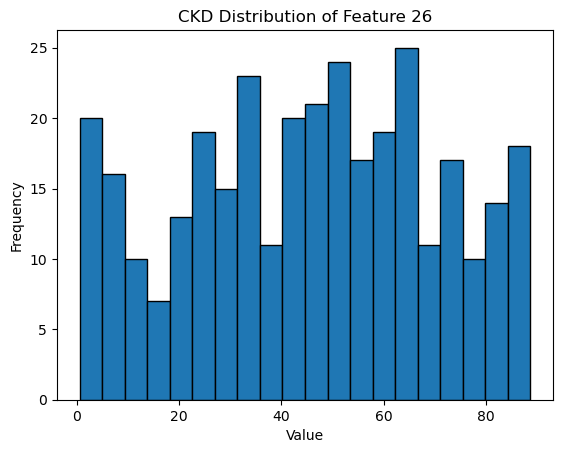

In [73]:
# Statistical Analysis Block

# Class for the analysis
class Stat_analysis:
    def __init__(self, data, name, save_folder):
        self.data = data
        self.name = name
        self.save_folder = save_folder
        self.feature_distribution()
        self.class_distrubution()

    # Function to create a distribution for each feature
    def feature_distribution(self):
        for i in range(self.data.shape[1] - 2): # remove 1 and last column as we do not need them for the distribution of the features
            feature_num = i + 1

            plt.hist(self.data[:,feature_num], bins=20, edgecolor="black")
            plt.xlabel("Value")
            plt.ylabel("Frequency")
            plt.title(f"{self.name} Distribution of Feature {feature_num}")

            filename = os.path.join(self.save_folder, f"{self.name}_feature{feature_num}_distribution.png")
            plt.savefig(filename, dpi=300, bbox_inches="tight")
            plt.close()
    
    # Function to create a distribution for the class
    def class_distrubution(self):
        my_bins = [-0.5, 0.5, 1.5]
        class_0 = "Normal"
        if self.name == "CKD":
            class_1 = "CKD"
        else:
            class_1 = "Defective"

        plt.hist(self.data[:,self.data.shape[1] - 1], bins=my_bins, edgecolor="black", align="mid", rwidth=0.6)
        plt.xticks([0, 1], [class_0, class_1])
        plt.xlabel("Category")
        plt.ylabel("Frequency")
        plt.title(f"{self.name} Distribution of Class")

        filename = os.path.join(self.save_folder, f"{self.name}_class_distribution.png")
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.close()

# Perform the stastical analysis
CKD_stat = Stat_analysis(CKD_data, "CKD", "CKD_distribution")
battery_stat = Stat_analysis(battery_data, "Battery", "Battery_distribution")




In [ ]:
class Model:
    def __init__(self,  dataframe, data_array, description:str = None):
        self.max_iteration = 1000
        self.tolerance = 10**-3
        self.step_size = 0.001

        self.dataframe = dataframe
        self.data_array = data_array
        self.description = description
        
        self.accuracy_arr = 0
        self.avg_accuracy = 0
        
        self.weigth_arr = 0
        self.avg_weigth = 0
    
    def normalize(self, normalize_by_max:bool, standardize:bool): 
        # Normalize the dataset
        # I think you should only normalize by max OR standardize, and I think standardizing would produce better results

        # Separate features and target
        df = self.dataframe # make sure data is a data frame
        features = df.drop(['ID', 'label'], axis=1)
        target = df['label']

        df_norm = df # if normalize_by_max = false and standardize = false, will return original df

        if normalize_by_max:
            # normalizing by extremas, scales to [0,1]
            # ensures data is well-conditioned
            features_normalized = (features - features.min())/(features.max() - features.min())
            df_norm = pd.concat([df[['ID']], features_normalized, df[['label']]], axis=1)

        if standardize:
            # z score normalization, good for gaussian distributions
            # forces std 1 and mean 0
            features_standardized = (features - features.mean())/features.std()
            df_norm = pd.concat([df[['ID']], features_standardized, df[['label']]], axis=1)

        # returns a pandas dataframe
        return df_norm
    
    def crossValidation(self, folds:int): 
        # Split dataset into folds
        # I think that self.data should only include non test data
        data = self.data_array[:,1:] # removing first column (ID)
        fold_size = len(data) // folds
        validation_experiments = []
        train_experiments = []

        for i in range(folds):
            if i==(folds-1):
                # how should i deal with uneven split ??? is it okay for the last fold to be smaller?
                validation_fold = data[(i*fold_size):]  #df.iloc[(i*fold_size):(len(df))]
                train_fold = data[:(i*fold_size)] #pd.concat([df.iloc[:(i*fold_size)], df.iloc[(len(df)):]])

            else:
                validation_fold = data[(i*fold_size):(i*fold_size + fold_size)] #df.iloc[(i*fold_size):(i*fold_size + fold_size)]
                train_fold = np.vstack([data[:(i*fold_size)], data[(i*fold_size + fold_size):]]) #pd.concat([df.iloc[:(i*fold_size)], df.iloc[(i*fold_size + fold_size):]])
            validation_experiments.append(validation_fold)
            train_experiments.append(train_fold)

        # Train
        avg_error = 0

        for i in range(folds):
            # train each training set with fit() to get weights
            train_experiment = train_experiments[i]
            w = self.fit(train_experiment)   

            # get errors 
            validation_experiment = validation_experiments[i]
            error = self.Accu_eval(w, validation_experiment)
            print("error",i,error)
            avg_error += error

        avg_error = avg_error/folds

        return avg_error

    def fit(self,train_data):
        
        # Trains using gradient descent: Lecture 5 slide 55-58

        w_prev = np.ones(train_data.shape[1])*0.1 # (number of columns of train_data - 1 to remove label, + 1 to account for bias term)
        
        w_new = np.zeros(len(w_prev))
        w_diff = 1

        delta = np.zeros(len(w_prev))

        for num_iter in range(1,self.max_iteration+1):
            
            for row_i in train_data:
                y_i = row_i[-1] # extracting value
                x_i = row_i # extracting features
                x_i[-1] = 1 # because of bias term

                
                delta += x_i*(y_i-self.predict(w_prev,x_i))
   
            w_new = w_prev + (self.step_size)*delta # to be able to reach better precision need to devide step size by num iteration
          
       
            w_diff = np.linalg.norm(w_new - w_prev)
            
            if (w_diff**2<self.tolerance):
                print(w_new, w_diff)
                return w_new
           
            
        # Means there was a problem
        print("Not converged", w_new , w_diff)
        
        return w_new

    
    def predict(self,w,x):
        # Predicts output: function at bottom Lecture 5 slide 44
        a = w.T @ x
        return 1/(1+np.exp(-a))

    def Accu_eval(self,w,validate_data): # Used MSE
        # Validation
        error = 0
        for row_i in validate_data:
            y_i = row_i[-1] # extracting value
            x_i = row_i # extracting features
            x_i[-1] = 1
            
            error += (y_i-self.predict(w,x_i))**2 
            
        return error/len(validate_data)



In [98]:
# testing whole model for CKD data with cross validation


ckd_model = Model(df_CKD, CKD_data, "This is the model for the CKD dataset")
features_ckd = df_CKD.drop(['ID', 'label'], axis=1)

def condition_number(features):
    A = features.to_numpy()
    U, S, V = np.linalg.svd(A, full_matrices=False)
    condition_num = np.max(S) / np.min(S[np.nonzero(S)])
    return condition_num

# normalize data
df_norm = ckd_model.normalize(True, False)
features_ckd_norm = df_norm.drop(['ID', 'label'], axis=1)
ckd_model_norm = Model(df_norm, df_norm.to_numpy())

# standardize data
df_stand = ckd_model.normalize(False, True)
features_ckd_stand = df_stand.drop(['ID', 'label'], axis=1)
ckd_model_stand = Model(df_stand, df_stand.to_numpy())

#print("Condition number of original dataset : ", condition_number(features_ckd))
print("Condition number of normalized dataset : ", condition_number(features_ckd_norm))
#print("Condition number of standardized dataset : ", condition_number(features_ckd_stand))
print("---------------------------------------------------------")
#print("Error after training original dataset : ", ckd_model.crossValidation(10))
print("Error after training normalized dataset : ", ckd_model_norm.crossValidation(10))
#print("Error after training standardized dataset : ", ckd_model_stand.crossValidation(10))


Condition number of normalized dataset :  16.272627194785652
---------------------------------------------------------
[0.09305457 0.12031234 0.09965432 0.10245777 0.0990079  0.10192303
 0.09837018 0.09888188 0.09696958 0.09804202 0.10038985 0.10306272
 0.10041333 0.10082486 0.09852403 0.1003698  0.10134789 0.10358097
 0.10166464 0.09983097 0.10324633 0.09573147 0.09630996 0.10107247
 0.09966857 0.10206684 0.10094803 0.10152477 1.00385723] 0.02418147443655488
error 0 0.4880837076031561
[0.08962878 0.11789048 0.09852074 0.10125853 0.09793085 0.10048941
 0.09678511 0.09979423 0.09725232 0.09744533 0.10078931 0.10173881
 0.09818485 0.09932404 0.09877482 0.10029093 0.09874633 0.10099428
 0.09854942 0.09826141 0.10065192 0.09363165 0.09641249 0.09903566
 0.09771693 0.09781674 0.09903879 0.10066346 1.00077877] 0.023319094254606265
error 1 0.4109705910106376
[0.08867602 0.11766468 0.0990184  0.09902133 0.09681543 0.09786049
 0.09749291 0.0986908  0.09723366 0.09738293 0.10040656 0.10093526
 0